# DNS Tunneling Detection

Dataset Credits : https://github.com/netrack/learn

In [1]:
import time
import math
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import warnings
import pickle
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv("train.csv")
train_data.head()

,Label,Query
0,1,q+Z8AnwaBA.hidemyself.org.
1,1,q+Z8A3wbBA.hidemyself.org.
2,1,q+Z8BHwcBA.hidemyself.org.
3,1,q+Z8BXwdBA.hidemyself.org.
4,1,q+Z8BnweCORdAGL4+W7DB5xH1cUwcwM1gejAQoJF8hbs2J...


In [3]:
test_data = pd.read_csv("test.csv")
test_data.head()

,Label,Query
0,1,0a4aaL5kV6eOeQS0A2SOSZvUa5uRRa5Xd2wXQg45.gQOqC...
1,1,r51646.tunnel.tuns.org.
2,1,dIUEABDEZOBAAAQAGRTXQUAAAAMFAAAAC37CAAFUWXXFR6...
3,1,dIUEABDEVJZAAAQAGSEIQUAAAAMFAAAAC37HAAFQ4GERG7...
4,0,site.tycrabtree.com


1    12000
0     3000
Name: Label, dtype: int64


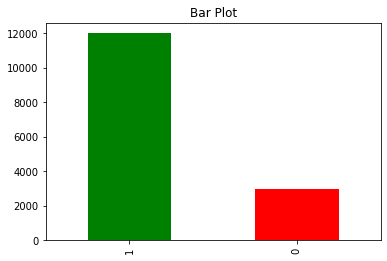

In [4]:
counts = train_data['Label'].value_counts()
print(counts)
counts.plot(kind = 'bar',color = ["green","red"])
plt.title('Bar Plot')
plt.show()

0    11291
1     8709
Name: Label, dtype: int64


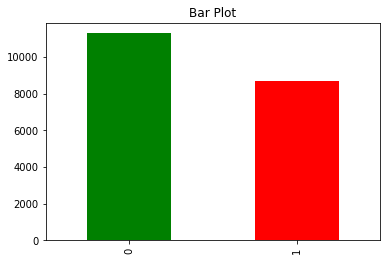

In [5]:
counts = test_data['Label'].value_counts()
print(counts)
counts.plot(kind = 'bar',color = ["green","red"])
plt.title('Bar Plot')
plt.show()

# Finding Entropy from data

In [6]:
def find_entropy(text):
    if not text: 
        return 0 
    entropy = 0
    for x in range(256): 
        p_x = float(text.count(chr(x)))/len(text) 
        if p_x > 0: 
            entropy += - p_x*math.log(p_x, 2) 
    return entropy

In [7]:
train_entropy_vals = []

for query in train_data['Query']:
    entropy = find_entropy(query)
    train_entropy_vals.append(entropy)

train_data['Entropy'] = train_entropy_vals
train_data.head()

,Label,Query,Entropy
0,1,q+Z8AnwaBA.hidemyself.org.,4.363713
1,1,q+Z8A3wbBA.hidemyself.org.,4.363713
2,1,q+Z8BHwcBA.hidemyself.org.,4.363713
3,1,q+Z8BXwdBA.hidemyself.org.,4.286790
4,1,q+Z8BnweCORdAGL4+W7DB5xH1cUwcwM1gejAQoJF8hbs2J...,5.752803


In [8]:
test_entropy_vals = []

for query in test_data['Query']:
    entropy = find_entropy(query)
    test_entropy_vals.append(entropy)

test_data['Entropy'] = test_entropy_vals
test_data.head()

,Label,Query,Entropy
0,1,0a4aaL5kV6eOeQS0A2SOSZvUa5uRRa5Xd2wXQg45.gQOqC...,5.537549
1,1,r51646.tunnel.tuns.org.,3.621176
2,1,dIUEABDEZOBAAAQAGRTXQUAAAAMFAAAAC37CAAFUWXXFR6...,5.092942
3,1,dIUEABDEVJZAAAQAGSEIQUAAAAMFAAAAC37HAAFQ4GERG7...,5.024586
4,0,site.tycrabtree.com,3.431624


# Data Processing

In [9]:
def PrintStats(y_pred, test_target):
    print("Number of mislabeled points out of a total %d points : %d"
      % (test_target.shape[0], (test_target != y_pred).sum()))

    test_target = test_target.to_numpy()
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for t in range(test_target.shape[0]):
        if test_target[t] == 0:
            if y_pred[t] == 1:
                fp += 1
            else:
                tn += 1
        else:
            if y_pred[t] == 1:
                tp += 1
            else:
                fn += 1

    print("True Positives :", tp)
    print("True Negatives :", tn)
    print("False Positives :", fp)
    print("False Negatives :", fn)

In [10]:
def mode(sample):
    c = Counter(sample)
    return [k for k, v in c.items() if v == c.most_common(1)[0][1]]

In [11]:
X_train = train_data['Entropy']
Y_train = train_data['Label']
X_test = test_data['Entropy']
Y_test = test_data['Label']

In [12]:
X_train, Y_train = shuffle(X_train, Y_train)
X_test, Y_test = shuffle(X_test, Y_test)

In [13]:
X_train.head()

11097    5.329304
9653     5.641680
11499    5.587173
3450     5.783822
6795     3.640224
Name: Entropy, dtype: float64

In [14]:
X_train = X_train.values.reshape(-1, 1)
Y_train = Y_train.values.reshape(-1, 1)
X_test  = X_test.values.reshape(-1, 1)

# Decision Tree, KNN and Gaussian Naive Bayes

In [96]:
start = time.time()

model1 = DecisionTreeClassifier()
model2 = KNeighborsClassifier(n_neighbors = 2)
model3 = GaussianNB()

model1.fit(X_train, Y_train.ravel())
model2.fit(X_train, Y_train.ravel())
model3.fit(X_train, Y_train.ravel())

pred1 = model1.predict(X_test)
pred2 = model2.predict(X_test)
pred3 = model3.predict(X_test)

final_pred = np.array([])
for i in range(0,len(X_test)):
    final_pred = np.append(final_pred, mode([pred1[i], pred2[i], pred3[i]]))

end = time.time()
print("The time taken is: ",(end-start)*1000,"millisec")
PrintStats(final_pred, Y_test)

The time taken is:  1229.9578189849854 millisec
Number of mislabeled points out of a total 20000 points : 1722
True Positives : 8708
True Negatives : 9570
False Positives : 1721
False Negatives : 1


In [97]:
print("The accuracy is: ",accuracy_score(Y_test, final_pred)*100,"%")

The accuracy is:  91.39 %


In [98]:
print(classification_report(Y_test, final_pred))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92     11291
           1       0.83      1.00      0.91      8709

    accuracy                           0.91     20000
   macro avg       0.92      0.92      0.91     20000
weighted avg       0.93      0.91      0.91     20000



# Random Forest, Decision Tree and Quadratic SVM

In [99]:
start = time.time()

model1 = RandomForestClassifier(n_estimators = 100)
model2 = DecisionTreeClassifier() 
model3 = SVC(kernel='poly', degree=2, gamma='scale')

model1.fit(X_train, Y_train.ravel())
model2.fit(X_train, Y_train.ravel())
model3.fit(X_train, Y_train.ravel())

pred1 = model1.predict(X_test)
pred2 = model2.predict(X_test)
pred3 = model3.predict(X_test)

final_pred = np.array([])
for i in range(0,len(X_test)):
    final_pred = np.append(final_pred, mode([pred1[i], pred2[i], pred3[i]]))

print(final_pred)
end = time.time()
print("The time taken is: ",(end-start)*1000,"millisec")
PrintStats(final_pred, Y_test)

[1. 1. 0. ... 0. 0. 1.]
The time taken is:  3283.907890319824 millisec
Number of mislabeled points out of a total 20000 points : 1795
True Positives : 8708
True Negatives : 9497
False Positives : 1794
False Negatives : 1


In [100]:
print("The accuracy is: ",accuracy_score(Y_test, final_pred)*100,"%")

The accuracy is:  91.025 %


In [101]:
print(classification_report(Y_test, final_pred))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91     11291
           1       0.83      1.00      0.91      8709

    accuracy                           0.91     20000
   macro avg       0.91      0.92      0.91     20000
weighted avg       0.93      0.91      0.91     20000



# Random Forest and Decision Tree

In [102]:
start = time.time()

model1 = RandomForestClassifier(n_estimators = 100)
model2 = DecisionTreeClassifier() 

model1.fit(X_train, Y_train.ravel())
model2.fit(X_train, Y_train.ravel())

pred1 = model1.predict(X_test)
pred2 = model2.predict(X_test)

final_pred = np.array([])
for i in range(0,len(X_test)):
    final_pred = np.append(final_pred, mode([pred1[i], pred2[i]]))

end = time.time()
print("The time taken is: ",(end-start)*1000,"millisec")
PrintStats(final_pred, Y_test)

The time taken is:  1923.2144355773926 millisec
Number of mislabeled points out of a total 20000 points : 1795
True Positives : 8708
True Negatives : 9497
False Positives : 1794
False Negatives : 1


In [103]:
print("The accuracy is: ",accuracy_score(Y_test, final_pred)*100,"%")

The accuracy is:  91.025 %


In [104]:
print(classification_report(Y_test, final_pred))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91     11291
           1       0.83      1.00      0.91      8709

    accuracy                           0.91     20000
   macro avg       0.91      0.92      0.91     20000
weighted avg       0.93      0.91      0.91     20000



# Random Forest, Decision Tree and KNN

In [16]:
start = time.time()

model1 = RandomForestClassifier(n_estimators = 100)
model2 = DecisionTreeClassifier() 
model3 = KNeighborsClassifier(n_neighbors = 2)

model1.fit(X_train, Y_train.ravel())
model2.fit(X_train, Y_train.ravel())
model3.fit(X_train, Y_train.ravel())

pred1 = model1.predict(X_test)
pred2 = model2.predict(X_test)
pred3 = model3.predict(X_test)

final_pred = np.array([])
for i in range(0,len(X_test)):
    final_pred = np.append(final_pred, mode([pred1[i], pred2[i], pred3[i]]))

end = time.time()
print("The time taken is: ",(end-start)*1000,"millisec")
PrintStats(final_pred, Y_test)

The time taken is:  1330.770492553711 millisec
Number of mislabeled points out of a total 20000 points : 1795
True Positives : 8708
True Negatives : 9497
False Positives : 1794
False Negatives : 1


In [17]:
print("The accuracy is: ",accuracy_score(Y_test, final_pred)*100,"%")

The accuracy is:  91.025 %


In [18]:
print(classification_report(Y_test, final_pred))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91     11291
           1       0.83      1.00      0.91      8709

   micro avg       0.91      0.91      0.91     20000
   macro avg       0.91      0.92      0.91     20000
weighted avg       0.93      0.91      0.91     20000

